In [ ]:
<div style="background-color: #f8b195; padding: 5px;">
<h2 style="padding:0px 0px;"> Objective: Test certain hypothesis about data. </h2>

<div class="alert alert-info"><h3>SQLMR User guide </h3>

https://docs.teradata.com/r/Enterprise_IntelliFlex_VMware/Teradata-VantageTM-Analytics-Database-Analytic-Functions-17.20

</div>

In [1]:
%connect legion-demo

Password: ········


Success: 'legion-demo' connection established and activated for user 'artur-borycki_teradata', with default database 'legion-demo'


<h3 style="padding:0px 0px;"> Input creation </h3>

In [2]:
create view hpt_input as (
  select a.MaxTemp as MountGambier, b.MaxTemp as Dartmoor, c.MaxTemp as Canberra from
    (select dt.MaxTemp,row_number() over (ORDER BY 1) id from weather dt where dt.loc = 'MountGambier') a,
    (select dt.MaxTemp,row_number() over (ORDER BY 1) id from weather dt where dt.loc = 'Dartmoor') b,
    (select dt.MaxTemp,row_number() over (ORDER BY 1) id from weather dt where dt.loc = 'Canberra') c where a.id = b.id and b.id = c.id
);

Success: 0 rows affected

In [3]:
select top 30 * from hpt_input;

,MountGambier,Dartmoor,Canberra
1,12.7,34.8,26.1
2,20.3,19.7,27.5
3,24,14.1,36.9
4,20.7,24.1,17.1
5,15.9,31.4,28.6
6,25.3,18.7,35.2
7,20.2,14.4,29.4
8,20.4,13.2,13.8
9,15.4,12.5,18.1
10,18.6,22.8,23.7


<h3 style="padding:0px 0px;">1.3.1 Is there any significant difference (>5%) in MaxTemp of MountGambier and Dartmoor based on their means?</h3>

In [4]:
select * from td_anova (
  on hpt_input as InputTable
  USING
  GroupColumns ('MountGambier','Dartmoor')
  Alpha(0.05)
) as dt;

,sum_of_squares(between groups),sum_of_squares(within groups),df(between groups),df(within groups),mean_square(between groups),mean_square(within groups),f_statistic,alpha,critical_f,p_value,conclusion
1,20.625429197546097,244123.5856699599,1,5948,20.625429197546097,41.04297001848687,0.5025325698470613,0.05,3.843022697505213,0.47841722457825303,Fail to reject Null hypothesis 


In [5]:
select * from TD_UnivariateStatistics (
  on (select * from weather where loc = 'MountGambier' or loc = 'Dartmoor' or loc = 'Canberra') as InputTable
  using
  TargetColumns ('MaxTemp')
  PartitionColumns('Loc')
  Stats('MEAN')
) as dt ORDER BY 1,3;

,Loc,Attribute,StatName,StatValue
1,Canberra,MaxTemp,MEAN,20.976638508593062
2,Dartmoor,MaxTemp,MEAN,19.697454175152785
3,MountGambier,MaxTemp,MEAN,19.828995057660613


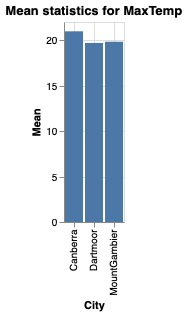

In [5]:
%chart x=Loc, y=StatValue, title="Mean statistics for MaxTemp", labelx=City, labely=Mean

In [30]:
select * from TD_UnivariateStatistics (
  on (select * from weather where loc = 'MountGambier' or loc = 'Dartmoor' or loc = 'Canberra') as InputTable
  using
  TargetColumns ('MaxTemp')
  PartitionColumns('Loc')
  Stats('VAR')
) as dt ORDER BY 1,3;

,Loc,Attribute,StatName,StatValue
1,Canberra,MaxTemp,VARIANCE,48.90026993251418
2,Dartmoor,MaxTemp,VARIANCE,41.61167093592988
3,MountGambier,MaxTemp,VARIANCE,40.51773514664655


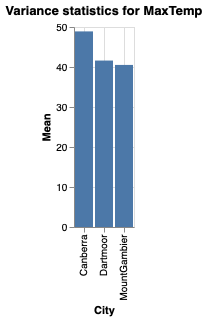

In [31]:
%chart x=Loc, y=StatValue, title="Variance statistics for MaxTemp", labelx=City, labely=Mean

<h3 style="padding:0px 0px;">1.3.2 Repeat the above analysis for three cities MountGambier, Dartmoor and Canberra.</h3>

In [32]:
select * from td_anova (
  on hpt_input as InputTable
  USING
  GroupColumns ('MountGambier','Dartmoor','Canberra')
  Alpha(0.05)
) as dt;

,sum_of_squares(between groups),sum_of_squares(within groups),df(between groups),df(within groups),mean_square(between groups),mean_square(within groups),f_statistic,alpha,critical_f,p_value,conclusion
1,2967.8559888573022,390596.31139278435,2,8953,1483.9279944286511,43.62742224871935,34.01365283442138,0.05,2.996734888780283,1.922632111182632e-15,Reject Null hypothesis 


<h3 style="padding:0px 0px;">1.3.3 Repeat the above analysis based on difference in their variances.</h3>

In [33]:
select * from td_ftest (
  on hpt_input as InputTable
  USING
  FirstSampleColumn('MountGambier')
  SecondSampleColumn('Dartmoor')
  AlternativeHypothesis('two-tailed')
  Alpha(0.05)
) as dt;

,firstsamplevariance,secondsamplevariance,varianceratio,df1,df2,CriticalValue,Alpha,p_value,Conclusion
1,40.554838844022335,41.61167093593048,0.9746025077066635,3003,2945,1.0745310683982727,0.05,0.4829842486879965,Fail to reject Null hypothesis


In [34]:
select * from td_ftest (
  on hpt_input as InputTable
  USING
  FirstSampleColumn('Dartmoor')
  SecondSampleColumn('Canberra')
  AlternativeHypothesis('two-tailed')
  Alpha(0.05)
) as dt;

,firstsamplevariance,secondsamplevariance,varianceratio,df1,df2,CriticalValue,Alpha,p_value,Conclusion
1,41.61167093593033,48.39055667588814,0.859913044907467,2945,3005,1.0745462496947427,0.05,3.917433809555317e-05,Reject Null hypothesis


<h3 style="padding:0px 0px;">1.3.4 Assuming the groups follow normal distribution for MaxTemp, repeat the above analysis with z-test.</h3>

<h4 style="padding:0px 0px;">Check the distribution</h4>

In [35]:
select * from td_histogram (
  on (select * from weather where loc = 'MountGambier') as InputTable
  USING 
  MethodType ('Equal-width')
  TargetColumn ('MaxTemp')
  NBins(30)
) as dt;

,ColumnName,Label,MinValue,MaxValue,CountOfValues,Bin_Percent
1,MaxTemp,1,9.423333333333332,10.646666666666667,19,0.6260296540362438
2,MaxTemp,9,19.21,20.433333333333334,210,6.919275123558484
3,MaxTemp,4,13.093333333333334,14.316666666666666,348,11.466227347611202
4,MaxTemp,0,8.2,9.423333333333332,3,0.09884678747940692
5,MaxTemp,2,10.646666666666667,11.87,56,1.8451400329489294
6,MaxTemp,10,20.433333333333334,21.656666666666666,188,6.194398682042833
7,MaxTemp,7,16.763333333333335,17.986666666666665,240,7.907742998352553
8,MaxTemp,6,15.54,16.763333333333335,250,8.237232289950576
9,MaxTemp,3,11.87,13.093333333333334,182,5.996705107084019
10,MaxTemp,11,21.656666666666666,22.88,162,5.337726523887974


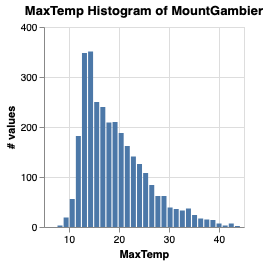

In [36]:
%chart x=Minvalue, y=CountOfValues, title="MaxTemp Histogram of MountGambier", labelx=MaxTemp, labely=# values

In [37]:
select * from td_histogram (
  on (select * from weather where loc = 'Dartmoor') as InputTable
  USING 
  MethodType ('Equal-width')
  TargetColumn ('MaxTemp')
  NBins(30)
) as dt;

,ColumnName,Label,MinValue,MaxValue,CountOfValues,Bin_Percent
1,MaxTemp,1,8.343333333333334,9.586666666666666,2,0.0678886625933469
2,MaxTemp,9,18.29,19.53333333333333,218,7.399864222674814
3,MaxTemp,4,12.073333333333332,13.316666666666666,251,8.520027155465037
4,MaxTemp,0,7.1,8.343333333333334,2,0.0678886625933469
5,MaxTemp,2,9.586666666666666,10.829999999999998,28,0.9504412763068567
6,MaxTemp,10,19.53333333333333,20.776666666666664,195,6.619144602851323
7,MaxTemp,7,15.803333333333333,17.046666666666667,232,7.875084860828243
8,MaxTemp,6,14.559999999999999,15.803333333333333,360,12.219959266802444
9,MaxTemp,3,10.829999999999998,12.073333333333332,78,2.6476578411405294
10,MaxTemp,11,20.776666666666664,22.019999999999996,166,5.634758995247793


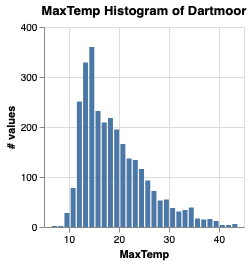

In [38]:
%chart x=Minvalue, y=CountOfValues, title="MaxTemp Histogram of Dartmoor", labelx=MaxTemp, labely=# values

In [39]:
select * from td_histogram (
  on (select * from weather where loc = 'Canberra') as InputTable
  USING 
  MethodType ('Equal-width')
  TargetColumn ('MaxTemp')
  NBins(30)
) as dt;

,ColumnName,Label,MinValue,MaxValue,CountOfValues,Bin_Percent
1,MaxTemp,1,5.363333333333333,6.626666666666666,0,0
2,MaxTemp,9,15.469999999999999,16.733333333333334,215,6.262743955723857
3,MaxTemp,4,9.153333333333332,10.416666666666666,49,1.4273230410719489
4,MaxTemp,0,4.1,5.363333333333333,1,0.029129041654529564
5,MaxTemp,2,6.626666666666666,7.889999999999999,10,0.29129041654529564
6,MaxTemp,10,16.733333333333334,17.996666666666663,188,5.476259831051558
7,MaxTemp,7,12.943333333333332,14.206666666666665,265,7.719196038450335
8,MaxTemp,6,11.68,12.943333333333332,196,5.709292164287795
9,MaxTemp,3,7.889999999999999,9.153333333333332,29,0.8447422079813574
10,MaxTemp,11,17.996666666666663,19.259999999999998,193,5.621905039324206


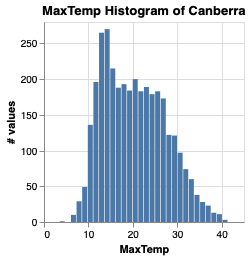

In [40]:
%chart x=Minvalue, y=CountOfValues, title="MaxTemp Histogram of Canberra", labelx=MaxTemp, labely=# values

<h4 style="padding:0px 0px;">Perform z-test</h4>

In [41]:
select * from td_ztest (
  on hpt_input as InputTable
  USING
  FirstSampleColumn('MountGambier')
  SecondSampleColumn('Dartmoor')
  AlternativeHypothesis('two-tailed')
  Alpha(0.05)
) as dt;

,firstsamplecolumn,secondsamplecolumn,N1,N2,mean1,mean2,AlternativeHypothesis,z_score,Alpha,CriticalValue,p_value,Conclusion
1,MountGambier,Dartmoor,3004,2946,19.810785619174446,19.697454175152753,TWO-TAILED,0.6833111734679748,0.05,1.9599639845400545,0.4944102352256666,Fail to reject Null hypothesis 


<h3 style="padding:0px 0px;">1.3.5 Check if location has any statistically significant (>5%) influence on RainTomorrow?</h3>

<h4 style="padding:0px 0px;">Prepare contingency table</h4>

In [4]:
create view contingency_table as (
  select loc, 
  sum (case when RainTomorrow = 'yes' then 1 else 0 end) as rain,
  sum (case when RainTomorrow = 'no'  then 1 else 0 end) as norain
  from weather group by loc
);

Success: 0 rows affected

In [5]:
select * from contingency_table order by 2;

,Loc,rain,norain
1,Uluru,116,1405
2,Woomera,202,2788
3,Nhil,242,1327
4,AliceSprings,244,2787
5,Katherine,265,1294
6,Mildura,327,2680
7,Cobar,386,2602
8,Moree,394,2460
9,SalmonGums,472,2483
10,PearceRAAF,505,2257


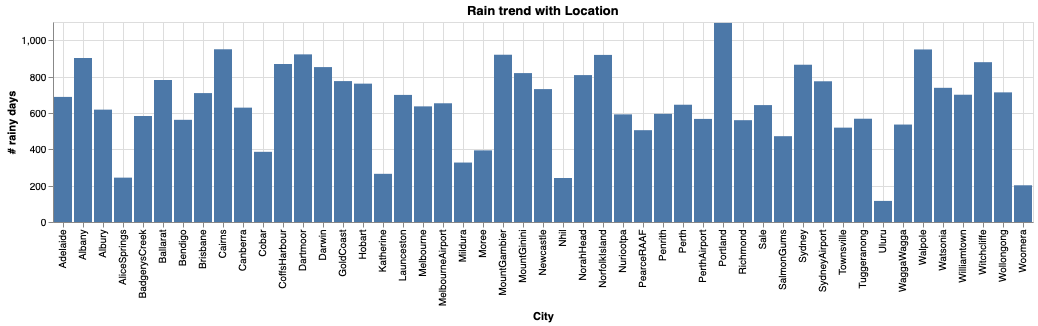

In [44]:
%chart x=Loc, y=rain, title="Rain trend with Location", labelx=City, labely=# rainy days

<h4 style="padding:0px 0px;">Perform Chisquare Test</h4>

In [10]:
drop table expected_table;

ERROR: Unable to run SQL: Unable to run SQL query: Database reported error:3807:Object 'expected_table' does not exist.

In [6]:
select * from td_chisq (
  on contingency_table as contingency
  OUT volatile TABLE ExpCounts (expected_table)
  USING 
  Alpha (0.05)
) as dt;

Success: 0 rows affected

,chi_square,cramers_v,df,alpha,p_value,criticalvalue,conclusion
1,3544.7901812832997,0.15789055760429338,48,0.05,0,65.17076890356984,Reject Null hypothesis 


In [7]:
select * from expected_table order by 2;

,Loc,rain,norain
1,Uluru,340.97963331528274,1180.0203666847171
2,Katherine,349.4985196177027,1209.5014803822974
3,Nhil,351.74033180255003,1217.2596681974499
4,Melbourne,545.881267010331,1889.118732989669
5,Williamtown,572.3346507915298,1980.6653492084702
6,PearceRAAF,619.1885254548396,2142.8114745451603
7,Walpole,631.9668549084695,2187.0331450915305
8,Moree,639.8131975554352,2214.186802444565
9,MountGinini,651.6948021351262,2255.3051978648737
10,BadgerysCreek,656.4026077233057,2271.5973922766943


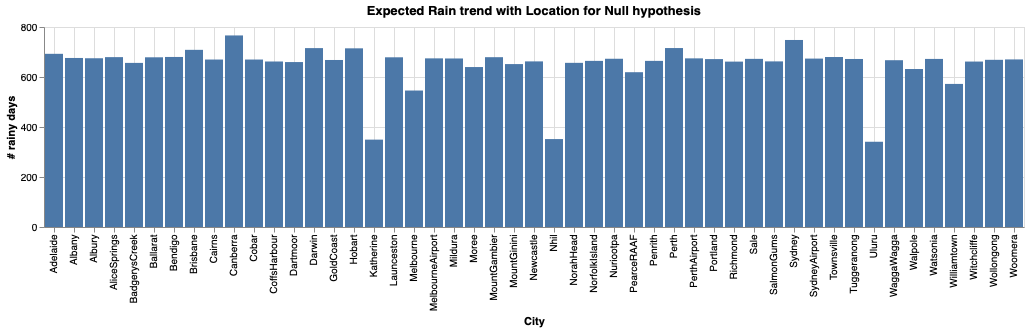

In [47]:
%chart x=Loc, y=rain, title="Expected Rain trend with Location for Null hypothesis", labelx=City, labely=# rainy days

<h3 style="padding:0px 0px;">1.3.6 Repeat the above test if only two cities are considered: Richmond and Bendigo.</h3>

<h4 style="padding:0px 0px;">Prepare contingency table</h4>

In [7]:
create view contingency_table1 as (
  select loc, 
  sum (case when RainTomorrow = 'yes' then 1 else 0 end) as rain,
  sum (case when RainTomorrow = 'no'  then 1 else 0 end) as norain
  from (select * from weather where loc = 'richmond' or loc = 'bendigo') dt group by loc
);

Success: 0 rows affected

In [53]:
select * from contingency_table1 order by 2;

,Loc,rain,norain
1,Richmond,560,2391
2,Bendigo,562,2472


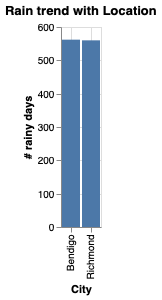

In [54]:
%chart x=Loc, y=rain, title="Rain trend with Location", labelx=City, labely=# rainy days

<h4 style="padding:0px 0px;">Perform Chisquare Test</h4>

In [55]:
drop table expected_table;

Success: 16 rows affected

In [56]:
select * from td_chisq (
  on contingency_table1 as contingency
  OUT TABLE ExpCounts (expected_table)
  USING 
  Alpha (0.05)
) as dt;

Success: 0 rows affected

,chi_square,cramers_v,df,alpha,p_value,criticalvalue,conclusion
1,0.20172676217800597,0.005805634375839775,1,0.05,0.6533306487503894,3.841458820694126,Fail to reject Null hypothesis 


In [57]:
select * from expected_table order by 2;

,Loc,rain,norain
1,Richmond,553.2200501253133,2397.7799498746867
2,Bendigo,568.7799498746867,2465.2200501253133


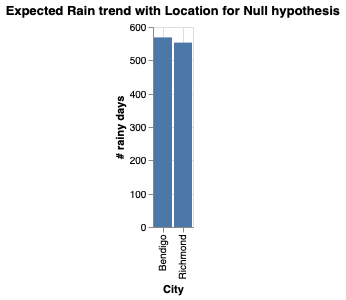

In [58]:
%chart x=Loc, y=rain, title="Expected Rain trend with Location for Null hypothesis", labelx=City, labely=# rainy days

In [59]:
drop table hpt_input;

ERROR: Unable to run SQL: Unable to run SQL query: Database reported error:3853:'hpt_input' is not a table.

In [25]:
drop table contingency_table;

Success: 18 rows affected

In [26]:
drop table expected_table;

Success: 17 rows affected